# Comprehensive Guide to Using And Querying Neo4j Graph Databases in Python

Sources: 
- https://www.datacamp.com/tutorial/neo4j-tutorial
- https://github.com/BexTuychiev/medium_stories/tree/ef28d856a6264d7681d2b27095fa532fe0791a0b/2024/9_september/3_neo4j_python

## Introduction to Graph Databases and Neo4j

Data scientists start learning about SQL from the cradle. That's understandable given the ubiquity and high usefulness of tabular information. However, there are other successful database formats like graph databases to store connected data that don't fit into a relational SQL database. In this tutorial, we will learn about Neo4j, a popular graph database management system, to create, manage and query graph databases in Python. 

### What are graph databases?


Before we start talking all about Neo4j, let's take a moment to understand graph databases better. 

Graph databases are a type of NoSQL databases (don't use SQL) designed for managing connected data. Unlike traditional relational databases that use tables and rows, graph databases use graph structures that are made up of:
- __Nodes (entities)__ such as people, places, concepts
- __Edges (relationships)__ that connect different nodes like _person_ LIVES IN _a place_, or _a football player_ SCORED IN _a match_. 
- __Properties (attributes for nodes/edges)__ like the age of a person, or when in the match the goal was scored.

This structure makes graph databases ideal for handling interconnected data in fields and applications such as social networks, recommendations, fraud detection, etc. often outperforming relational DBs in terms of querying efficiency. Here is a structure of a sample graph database for a football dataset:

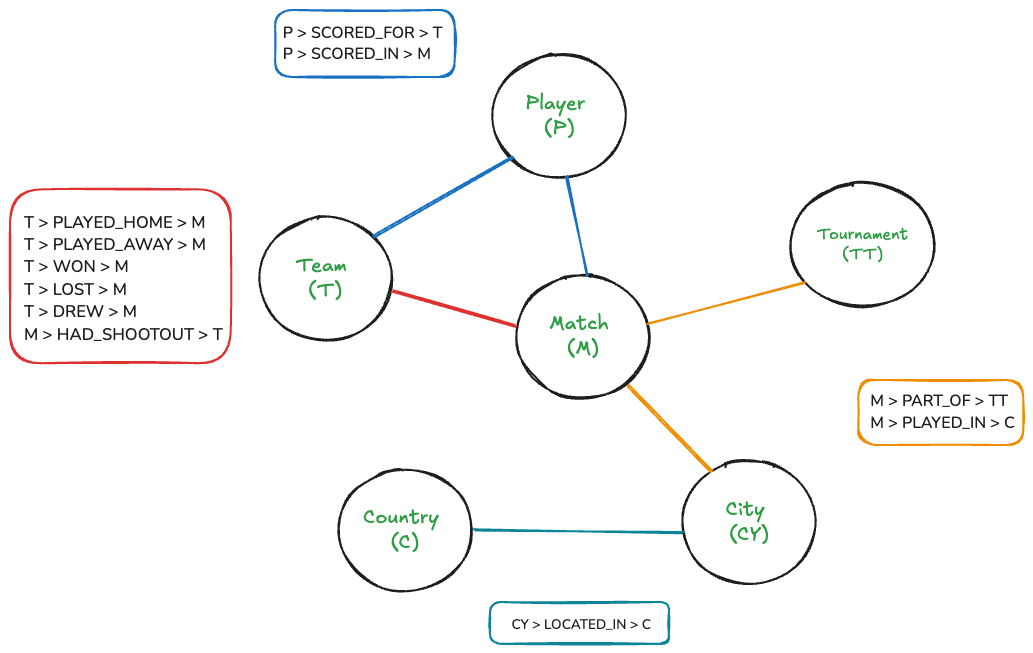

Even though this graph represents something fairly intuitive to humans, it can get pretty complicated if drawn on canvas. But with Neo4j, traversing this graph will be as straightforward as writing simple SQL joins. 

The graph has six nodes: Match, Team, Tournament, Player, Country and City. The rectangles list the relationships that exist between nodes. There are also a few node and relationship properties:
- Match: date, home_score, away_score
- Team: name
- Player: name
- Tournament: name
- City: name
- Country: name
- SCORED_FOR, SCORED_IN: minute, own_goal, penalty
- HAD_SHOOTOUT: winner, first_shooter


This schema allows us to represent:
- All matches with their scores, dates, and locations
- Teams participating in each match (home and away)
- Players scoring goals, including details like minute, own goals, and penalties
- Tournaments that matches are part of
- Cities and countries where matches are played
- Shootout information, including winners and first shooters (when available)

The schema captures the hierarchical nature of locations (City within Country) and the various relationships between entities (e.g., Teams playing Matches, Players scoring for Teams in Matches).

This structure allows for flexible querying, such as finding all matches between two teams, all goals scored by a player, or all matches in a specific tournament or location.

But let's not get ahead of ourselves. For starters, what is Neo4j and why use it?

### Why use Neo4j?


Neo4j, the leading name in the world of graph DB management, is known for its powerful features and versatility. 

At its core, Neo4j uses native graph storage, highly optimized to carry out graph operations. Its efficiency in handling complex relations makes it outperform traditional databases for connected data. Neo4j's scalability is truly impressive: it can handle billions of nodes and relationships with ease, making it suitable for both small projects and large enterprises. 

Another key aspect of Neo4j is data integrity. It ensures full ACID (Atomicity, Consistency, Isolation, Durability) compliance, providing reliability and consistency in transactions. 

Speaking of transactions, its query language, Cypher, offers a very intuitive and declarative syntax designed for graph patterns. For this reason, its syntax has been dubbed with the "ASCII art" nickname. Cypher will be no problem to learn, especially if you are familiar with SQL. 

With Cypher, it is easy to add new nodes, relationships or properties without worrying about breaking existing queries or schema. It is adaptable to rapidly changing requirements of modern development environments. 

Neo4j has a vibrant ecosystem support. It has extensive documentation, comprehensive tools to visualize graphs, active community and integrations with other programming languages such as Python, Java, and JavaScript.

## Setting Up Neo4j and a Python Environment


Before we dive into working with Neo4j, we need to set up our environment. This section will guide you through creating a cloud instance to host Neo4j databases, setting up a Python environment, and establishing a connection between the two.

### Not installing Neo4j

If you wish to work with local graph databases in Neo4j, then you would need to [download and install it locally](https://neo4j.com/docs/operations-manual/current/installation/) along with its dependencies like Java. But in majority of the cases, you will be interacting with an existing remote Neo4j database on some cloud environment. 

For this reason, we won't install Neo4j on our system. Instead, we will create a free database instance on [Aura](https://neo4j.com/product/auradb/), Neo4j's fully managed cloud service. Then, we will use the `neo4j` Python client library to connect to this database and populate it with data.

### Populating an Neo4JDB instance with football data

Run `neo4j-import-data.ipynb` file. 
The football data comes from [this Kaggle dataset on international football matches](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017/data) played between 1872 and 2024. The data is available in a CSV format, so the script breaks it down and converts it into graph format using Cypher and Neo4j. Towards the end of the article, when we are comfortable enough with these technologies, we will go through the script line-by-line so you can understand how to convert tabular information into a graph. 

The script may take a few minutes to run depending on your machine and Internet connection. But once it finishes, your AuraDB instance must show over 64k nodes and over 340k relationships. 

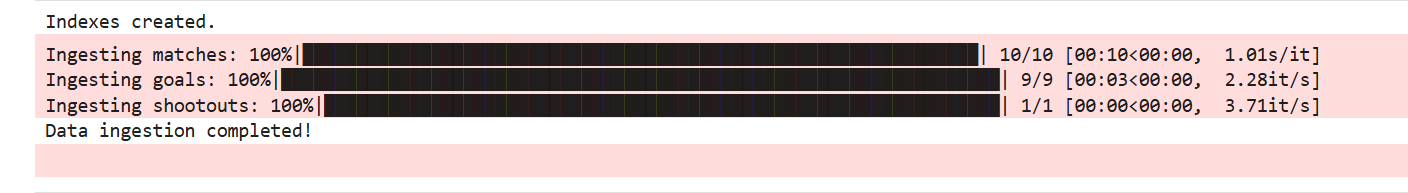
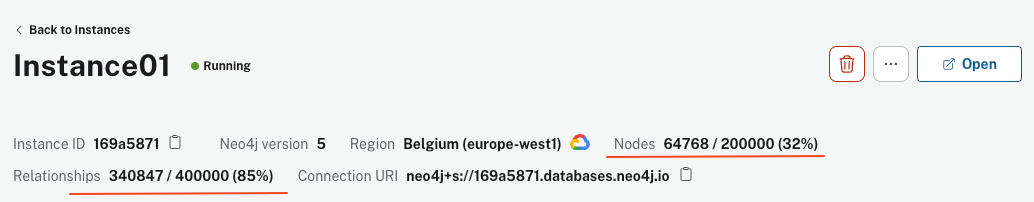

### Connecting to Neo4j From Python

Now, we are ready to connect to our DB instance.

Now, let's establish a connection:

In [ ]:
from neo4j import GraphDatabase

uri = "neo4j://localhost"
user = ""
password = ""

driver = GraphDatabase.driver(uri, auth=(user, password))

try:
    driver.verify_connectivity()
    print("Connection successful!")
except Exception as e:
    print(f"Failed to connect to Neo4j: {e}")

Here is an explanation of the code:

1. We import `GraphDatabase` from `neo4j` to interact with Neo4j.

2. We use the previously loaded environment variables to set up our connection (`uri`, `username`, `password`).

3. We create a driver object using `GraphDatabase.driver()`, establishing a connection to our Neo4j database.

4. Under a `with` block, we use the `verify_connectivity()` function to see if a connection is established. By default, `verify_connectivity()` returns nothing if a connection is successful. 

Once the tutorial finishes, call `driver.close()` to terminate the connection and free up resources. Driver objects are expensive to create, so you should only create a single object for your application.

## Cypher Query Language Essentials


Cypher's syntax is designed to be intuitive and visually representative of graph structures. It relies on the following ascii-art type of syntax:

```sql
(nodes)-[:CONNECT_TO]->(other_nodes)
```

Let's break down the key components of this general query pattern:

1. **Nodes**: 

In a Cypher query, a keyword in parentheses signifies a node name. For example, `(Player)` matches all Player nodes. Almost always, node names are referred to with aliases to make queries more readable, easier to write and compact. You can add an alias to a node name by putting a colon before it: `(m:Match)`. 

Inside the parentheses, you can specify one or more node properties for precise matching using dictionary-like syntax. For example:

```sql
// All tournament nodes that are FIFA World Cup
`(t:Tournament {name: "FIFA World Cup"})`
```

Node properties are written as-is while the value you want them to have must be a string. 

2. **Relationships**:

Relationships connect nodes to each other and they are wrapped with square brackets and arrows:

```sql
// Match nodes that are PART_OF some tournament
(m:Match)-[PART_OF]->(t:Tournament)
```

You can add aliases and properties to relationships as well:

```sql
// Matches that Brazil participated in a penalty shootout and was the first shooter
(p:Player) - [r:SCORED_FOR {minute: 90}] -> (t:Team)
```

Relationships are wrapped with arrows `-[RELATIONSHIP]->`. Again, you can include aliases properties inside braces. For example:

```sql
// All players who scored an own goal
(p:Player)-[r:SCORED_IN {own_goal: True}]->(m:Match)
``` 

3. **Clauses**:

Just like `COUNT(*) FROM table_name` would not return anything without a `SELECT` clause in SQL, `(node) - [RELATIONSHIP] -> (node)` wouldn't fetch any results. So, just like in SQL, Cypher has different clauses to structure your query logic like SQL:

- `MATCH`: Pattern matching in the graph
- `WHERE`: Filtering the results
- `RETURN`: Specifying what to include in the result set
- `CREATE`: Creating new nodes or relationships
- `MERGE`: Creating unique nodes or relationships
- `DELETE`: Removing nodes, relationships, or properties
- `SET`: Updating labels and properties

Here's a sample query that demonstrates these concepts:

```sql
MATCH (p:Player)-[s:SCORED_IN]->(m:Match)-[PART_OF]->(t:Tournament)
WHERE t.name = "FIFA World Cup" AND s.minute > 80 AND s.own_goal = True
RETURN p.name AS Player, m.date AS MatchDate, s.minute AS GoalMinute
ORDER BY s.minute DESC
LIMIT 5
```

This query finds all players who scored own goals in World Cup matches after the 80th minute mark. It reads almost like SQL but its SQL equivalent would involve at least one JOIN. 

## 4. Using Neo4j Python Driver to Analyze a Graph Database

### Running queries with `execute_query`

The Neo4j Python driver is the official library to interact with a Neo4j instance through Python applications. It verifies and communicates Cypher queries written in plain Python strings with a Neo4j server and retrieves the results in a unified format. 

It all starts by creating a driver object with the `GraphDatabase` class. From there, we can start sending queries using the `execute_query` method. 

For our first query, let's ask an interesting question - which team won the most number of World Cup matches?

In [ ]:
# Return the team that won the most number of World Cup matches
query = """
MATCH (t:Team)-[:WON]->(m:Match)-[:PART_OF]->(:Tournament {name: "FIFA World Cup"})
RETURN t.name AS Team, COUNT(m) AS MatchesWon
ORDER BY MatchesWon DESC
LIMIT 1
"""

records, summary, keys = driver.execute_query(query, database_="neo4j")

First, let's break down the query: 
- The `MATCH` close defines the pattern we want: Team -> Wins -> Match -> Part of -> Tournament
- `RETURN` is the equivalent of SQL's `SELECT` statement where we can return the properties of returned nodes and relationships. In this clause, you can also use [any supported aggregation function](https://neo4j.com/docs/cypher-manual/current/functions/) in Cypher. Above, we are using `COUNT`.
- `ORDER BY` clause works in the same manner as SQL's.
- `LIMIT` is used to control the length of the returned records. 

After we define the query as a multi-line string, we pass it to the `execute_query()` method of the driver object and specify the database name (the default is `neo4j`). The output always contains three objects:

- `records`: A list of Record objects, each representing a row in the result set. Each Record is a named tuple-like object where you can access fields by name or index.
- `summary`: A ResultSummary object containing metadata about the query execution, such as query statistics and timing information.
- `keys`: A list of strings representing the column names in the result set.

We will touch on the `summary` object later because we are mostly interested in `records`, which contain `Record` objects. We can retrieve their info by calling their `data()` method:

In [ ]:
for record in records:
    print(record.data())

And the result correctly shows that Brazil has won the most number of World Cup matches. 

### Passing query parameters

Our last query isn't reusable as it only finds the most successful team in World Cup history. What if we want to find the most successful team in Euro history? 

This is where query parameters come in:

In [ ]:
query = """
MATCH (t:Team)-[:WON]->(m:Match)-[:PART_OF]->(:Tournament {name: $tournament})
RETURN t.name AS Team, COUNT(m) AS MatchesWon
ORDER BY MatchesWon DESC
LIMIT $limit
"""

In this version of the query, we introduce two parameters using the `$` sign:
- `tournament`
- `limit`

To pass values to the query parameters, we use keyword arguments inside `execute_query`:

In [ ]:
records, summary, keys = driver.execute_query(
    query, database_="neo4j", tournament="UEFA Euro", limit=3,
)

for record in records:
    print(record.data())

It is always recommended to use query parameters whenever you are thinking of ingesting changing values into your query. This best practice protects your queries from Cypher injections and enables Neo4j to cache them. 

### Writing to databases with CREATE and MERGE clauses

Writing new information to an existing database is similarly done with `execute_query` but by using a `CREATE` clause in the query. For example, let's create a function that will add a new node type - team coaches:

In [ ]:
def add_new_coach(driver, coach_name, team_name, start_date, end_date):
    query = """
    MATCH (t:Team {name: $team_name})
    CREATE (c:Coach {name: $coach_name})
    CREATE (c)-[r:COACHES]->(t)
    SET r.start_date = $start_date
    SET r.end_date = $end_date
    """

    result = driver.execute_query(
        query,
        database_="neo4j",
        coach_name=coach_name,
        team_name=team_name,
        start_date=start_date,
        end_date=end_date
    )

    summary = result.summary
    print(f"Added new coach: {coach_name} for existing team {team_name} starting from {start_date}")
    print(f"Nodes created: {summary.counters.nodes_created}")
    print(f"Relationships created: {summary.counters.relationships_created}")

The function `add_new_coach` takes five parameters:
1. `driver`: The Neo4j driver object used to connect to the database.
2. `coach_name`: The name of the new coach to be added.
3. `team_name`: The name of the team the coach will be associated with.
4. `start_date`: The date when the coach starts coaching the team.
5. `end_date`: The date when the coach's tenure with the team ends.

The Cypher query in the function does the following:
1. Matches an existing Team node with the given team name.
2. Creates a new Coach node with the provided coach name.
3. Creates a COACHES relationship between the Coach and Team nodes.
4. Sets the `start_date` and `end_date` properties on the COACHES relationship.

The query is executed using the `execute_query` method, which takes the query string and a dictionary of parameters.

After execution, the function prints:
1. A confirmation message with the coach and team names, and start date.
2. The number of nodes created (should be 1 for the new Coach node).
3. The number of relationships created (should be 1 for the new COACHES relationship).

Let's run it for one of the most successful coaches in international football history, Lionel Scaloni, who won three consecutive major international tournaments (World Cup and two Copa Americas):

In [ ]:
from neo4j.time import DateTime

add_new_coach(
    driver=driver,
    coach_name="Lionel Scaloni",
    team_name="Argentina",
    start_date=DateTime(2018, 6, 1),
    end_date=None
)

In the above snippet, we are using the `DateTime` class from `neo4j.time` module to pass a date correctly into our Cypher query. The [module](https://neo4j.com/docs/python-manual/current/data-types/#_temporal_types) contains other useful temporal data types you may want to check out.

Apart from `CREATE`, there is also the `MERGE` clause for creating new nodes and relationships. Their key difference is:
- `CREATE` always creates new nodes/relationships, potentially leading to duplicates.
- `MERGE` only creates nodes/relationships if they don't already exist.

For example, in our data ingestion script, as you will see later:
- We used `MERGE` for teams and players to avoid duplicates.
- We used `CREATE` for `SCORED_FOR` and `SCORED_IN` relationships because a player can score multiple times in a single match.
-  These aren't true duplicates as they have different properties (e.g., goal minute).

This approach ensures data integrity while allowing for multiple similar but distinct relationships.

### Running your own transactions

When you run `execute_query`, the driver creates a _transaction_ under the hood. A transaction is a unit of work that is either executed in its entirety or rolled back as a failure. This means that when you are creating thousands of nodes or relationships in a single transaction (it is possible) and some error is encountered in the middle, the entire transaction fails without writing any new data to the graph.

To have a finer control over each transaction, you need to create session objects. For example, let's create a function to find the top K goal scores in a given tournament using a session object:

In [ ]:
def top_goal_scorers(tx, tournament, limit):
    query = """
    MATCH (p:Player)-[s:SCORED_IN]->(m:Match)-[PART_OF]->(t:Tournament)
    WHERE t.name = $tournament
    RETURN p.name AS Player, COUNT(s) AS Goals
    ORDER BY Goals DESC
    LIMIT $limit
    """

    result = tx.run(query, tournament=tournament, limit=limit)
    return [record.data() for record in result]

First, we create `top_goal_scorers` function that accepts three parameters, the most important one being the `tx` transaction object that will be obtained using a session object.

In [ ]:
with driver.session() as session:
    result = session.execute_read(top_goal_scorers, "FIFA World Cup", 5)
    for record in result:
        print(record)

Then, under a context manager created with the `session()` method, we use `execute_read()`, passing the `top_goal_scorers()` function, along with any parameters the query requires. 

The output of `execute_read` is a list of Record objects that correctly show the top 5 goal scorers in World Cup history, including names like Miroslav Klose, Ronaldo Nazario and Lionel Messi. 

Counterpart of `execute_read()` for data ingestion is `execute_write()`.

With that said, let's now look at the ingestion script we have used earlier to get a feel for how data ingestion works with the Neo4j Python driver.

## Conclusion and Next Steps


We've covered key aspects of working with Neo4j graph databases using Python:

1. Graph database concepts and structure
2. Setting up Neo4j AuraDB
3. Cypher query language basics
4. Using the Neo4j Python driver
5. Data ingestion and query optimization

To further your Neo4j journey, explore these resources:

1. [Neo4j Documentation](https://neo4j.com/docs/)
2. [Neo4j Graph Data Science Library](https://neo4j.com/docs/graph-data-science/current/)
3. [Neo4j Cypher Manual](https://neo4j.com/docs/cypher-manual/current/)
4. [Neo4j Python Driver Documentation](https://neo4j.com/docs/python-manual/current/)
5. [Data Engineering Career Certification by DataCamp](https://www.datacamp.com/certification/data-engineer)
6. [Introduction to NoSQL](https://www.datacamp.com/courses/introduction-to-nosql)
7. https://www.datacamp.com/tutorial/nosql-tutorial

Remember, the power of graph databases lies in representing and querying complex relationships. Keep experimenting with different data models and exploring advanced Cypher features.

Happy graphing!